In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import time
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## **MAIN CODE to get the rating and number of votes for each album**

In [30]:
df_ratings_scrapped = pd.read_csv('Datasets/df_ratings.csv')
start_id = df_ratings_scrapped['album_id'].iloc[-1]
start_id

317771

In [31]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import ftfy   # to fix names with unusual characters

df_ratings_scrapped = pd.read_csv('Datasets/df_ratings.csv', keep_default_na=False)

album_id_list = []
artists_list = []
albums_list = []
avg_rating_list = []
number_of_votes_list = []

count = 0
scrapped = 0

start_id = df_ratings_scrapped['album_id'].iloc[-1]

for album_id in range(start_id+1,start_id+20000):
    count+=1

    if album_id in df_ratings_scrapped['album_id'].values:
        print(f'{scrapped}/{count} - id {album_id}: album already scrapped')
        continue  # Skip this album, I already have it

    url = f'https://www.sputnikmusic.com/soundoff.php?albumid={album_id}'
    response = requests.get(f"{url}")
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Extract artist and album name
    info = soup.select('table tr')
    try:
        artist = info[2].text.split('dig it')[0].split('new music')[1].split('\xa0\xa0\xa0')[0].split('\n\n\n\n\n\n\n\n\n\n')[1]
        artist_name = ftfy.fix_text(artist)
        album = info[2].text.split('dig it')[0].split('new music')[1].split('\xa0\xa0\xa0')[1]
        album_name = ftfy.fix_text(album)     # fix the name 
    except IndexError:
        print(f"{scrapped}/{count} - id {album_id}: error")
        continue  # Skip this album if the info isn't formatted as expected
    if artist_name == '':
        print(f"{scrapped}/{count} - id {album_id}: No artist found")
        continue  # Skip this album if the info isn't formatted as expected

    print(f'{scrapped}/{count} - id {album_id}: {artist_name} - {album_name}')

    # Get ratings
    rating = soup.select('font.reviewheading b')
    ratings_list = []

    for r in rating:
        if len(r.text) == 3:  # Only consider ratings with 3 characters (like "4.5")
            ratings_list.append(r.text)

    # Convert to float
    rating_floats = [float(num) for num in ratings_list]
    
    if rating_floats:
        number_of_votes = len(rating_floats) # calculate the number of votes
        number_of_votes_list.append(number_of_votes) # save it in a list

        album_id_list.append(album_id)
        artists_list.append(artist_name)
        albums_list.append(album_name)

        avg_rating = round(np.mean(rating_floats),2) # calculate the avg rating
        avg_rating_list.append(avg_rating) # save it in a list

        scrapped+=1
    else:
        print(f"{scrapped}/{count} - id {album_id}: No valid ratings found.")

0/1 - id 317772: Julio Iglesias - A Flor De Piel
0/1 - id 317772: No valid ratings found.
0/2 - id 317773: Julio Iglesias - Ich Schick Dir Eine Weiße Wolke
0/2 - id 317773: No valid ratings found.
0/3 - id 317774: Julio Iglesias - El Amor
0/3 - id 317774: No valid ratings found.
0/4 - id 317775: Julio Iglesias - Manuela
0/4 - id 317775: No valid ratings found.
0/5 - id 317776: Julio Iglesias - A Mexico
0/5 - id 317776: No valid ratings found.
0/6 - id 317777: Julio Iglesias - America
0/6 - id 317777: No valid ratings found.
0/7 - id 317778: Julio Iglesias - Se Mi Lasci Non Vale
0/7 - id 317778: No valid ratings found.
0/8 - id 317779: Julio Iglesias - Schenk Mir Deine Liebe
0/8 - id 317779: No valid ratings found.
0/9 - id 317780: Julio Iglesias - A Mis 33 Años
0/9 - id 317780: No valid ratings found.
0/10 - id 317781: Julio Iglesias - Aimer La Vie
0/10 - id 317781: No valid ratings found.
0/11 - id 317782: Julio Iglesias - Manuela 1978
0/11 - id 317782: No valid ratings found.
0/12 - 

In [45]:
(169*60)/20000

0.507

## **Saving the data**

In [32]:
lists = [('album_id', album_id_list)
        , ('artists', artists_list)
         , ('albums', albums_list)
         , ('avg_rating', avg_rating_list)
         , ('number_of_votes', number_of_votes_list)
         ]

for name, lst in lists:
    print(f'{name}: {len(lst)}') # check that all lists have the same length (even though I had make sure with the previous code)

album_id: 13719
artists: 13719
albums: 13719
avg_rating: 13719
number_of_votes: 13719


In [33]:
# the new df with the artists I just scrapped
data = pd.DataFrame({'album_id': album_id_list
                    , 'artist': artists_list
                    , 'album': albums_list
                    , 'rating': avg_rating_list
                    , 'votes': number_of_votes_list})
print(f'{data.shape[0]} releases\n{data.artist.nunique()} different artists')

13719 releases
10295 different artists


In [34]:
print(f'I could webscrap {round(scrapped / count*100, 2)}% of the albums\n{scrapped} of {count} total albums')

I could webscrap 68.6% of the albums
13719 of 19999 total albums


In [35]:
print(f'{data[data['votes']<10].shape[0]} albums with < 10 votes, meaning {round((data[data['votes']<10].shape[0] / data.shape[0])*100,2)}% of the albums')
print(f'{data[data['votes']>10].shape[0]} of {data.shape[0]} actual valid albums')

12205 albums with < 10 votes, meaning 88.96% of the albums
1394 of 13719 actual valid albums


In [36]:
# most voted albums
data.sort_values('votes', ascending=False).head(10)

,album_id,artist,album,rating,votes
10432,333062,Tool,Fear Inoculum,3.60,1923
3345,322700,Slipknot,We Are Not Your Kind,3.56,1132
2770,321865,"Tyler, the Creator",Igor,3.82,1051
11902,335039,Blood Incantation,Hidden History Of The Human Race,4.03,1014
8217,330126,Cult of Luna,A Dawn to Fear,4.14,855
3718,323172,Opeth,In Cauda Venenum,3.46,837
10326,332906,Counterparts,Nothing Left to Love,3.99,822
7339,328807,Norma Jean,All Hail,3.95,734
5955,326747,Alcest,Spiritual Instinct,3.80,710
3832,323339,Knocked Loose,A Different Shade of Blue,3.69,649


In [37]:
# top rated albums 
data[data['votes']>100].sort_values('rating', ascending=False).head(10)

,album_id,artist,album,rating,votes
10714,333384,Cradle of Filth,Cruelty and the Beast - Re-Mistressed,4.41,109
8217,330126,Cult of Luna,A Dawn to Fear,4.14,855
8010,329823,Grouper,A I A: Alien Observer,4.11,149
11902,335039,Blood Incantation,Hidden History Of The Human Race,4.03,1014
10702,333364,Dance Gavin Dance,Acceptance Speech 2.0,4.02,201
1488,319888,State Faults,Clairvoyant,4.00,632
215,318079,Billy Woods and Kenny Segal,Hiding Places,3.99,228
10326,332906,Counterparts,Nothing Left to Love,3.99,822
3584,322990,Purple Mountains,Purple Mountains,3.99,262
11214,334053,Wilderun,Veil of Imagination,3.96,336


In [38]:
# plt.figure(figsize=(6,9))
# sns.countplot(data=data, y='votes')

## Concat with the df of the ratings previously scrapped

In [39]:
df_ratings_scrapped = pd.read_csv('Datasets/df_ratings.csv')
df_ratings_scrapped.shape

(233801, 5)

In [40]:
df_ratings = pd.concat([df_ratings_scrapped, data])
df_ratings.reset_index(drop=True, inplace=True)
df_ratings.shape

(247520, 5)

In [41]:
print(f'{df_ratings.shape[0]} albums\n{df_ratings.artist.nunique()} different artists')

247520 albums
91281 different artists


In [42]:
min_votes = 20

print(f'{round((df_ratings[df_ratings['votes']<min_votes].shape[0] / df_ratings.shape[0])*100,2)}% of the albums have less than {min_votes} votes')

81.52% of the albums have less than 20 votes


## **Exporting to csv (and importing in case needed)**

In [43]:
df_ratings.to_csv('Datasets/df_ratings.csv', index=False)

In [ ]:
# in case I have to import it again
# df_ratings = pd.read_csv('Datasets/df_ratings.csv', keep_default_na=False)

## **Handling null values**

In [163]:
df_ratings['album'].isna().sum()

57

In [145]:
df_ratings[df_ratings['album'].isna()].sort_values('votes')

,album_id,artist,album,rating,votes
13989,17721,Manic Hispanic,NaN,3.50,1
90937,112370,Deas Vail,NaN,4.50,1
91602,113267,dot three,NaN,3.50,1
208395,277251,Kousaki Satoru,NaN,4.50,1
92602,114581,Sebutones/Sixtoo,NaN,5.00,1
92604,114583,The Sebutones,NaN,5.00,1
93569,115802,The Be Happy Kids,NaN,3.50,1
106000,132394,Frigoris,NaN,3.00,1
107484,134407,Despot,NaN,5.00,1
114604,143943,Slander,NaN,4.00,1


In [143]:
df_ratings.shape

(216709, 5)

In [146]:
# drop the NaN albums that are no standard albums: compilations, lives...
df_ratings.drop([191321], inplace=True)

df_ratings.shape

(216706, 5)

In [ ]:
df_ratings.to_csv('Datasets/df_ratings.csv', index=False)

In [ ]:
# df_ratings.iloc[15417]['album']

'None'

In [ ]:
# replace the null values for the actual name of the album
# df_ratings['album'] = np.where(df_ratings['album_id']==35979, 'None' , df_ratings['album'])
# df_ratings.iloc[15417]['album']

'None'

## **Statistics**

**Top rated albums**

In [152]:
df_ratings.sort_values(['rating', 'votes'], ascending=False).query('votes>100').head(5)

,album_id,artist,album,rating,votes
19053,23820,Sigur Ros,Heima (DVD),4.65,388
414,531,Pink Floyd,Wish You Were Here,4.63,7065
33320,40844,Pink Floyd,Live At Pompeii,4.62,363
1897,2532,Deep Purple,Made In Japan,4.61,513
9210,11956,The Who,Live at Leeds (Deluxe Edition),4.59,184


**Most voted albums**

In [153]:
df_ratings.sort_values('votes', ascending=False).head(5)

,album_id,artist,album,rating,votes
1249,1484,Radiohead,OK Computer,4.54,9186
59,116,Metallica,Master Of Puppets,4.45,8950
69,130,Pink Floyd,The Dark Side Of The Moon,4.55,8048
148,222,Metallica,Ride The Lightning,4.42,8013
152,226,Radiohead,Kid A,4.43,7685


In [154]:
df_ratings.artist.value_counts().head(10)

artist
Bull Of Heaven             367
Buckethead                 285
Soundtrack (Film)          248
Various Artists            247
John Zorn                  102
Psychic TV                  92
Soundtrack (Video Game)     84
Miles Davis                 82
Frank Zappa                 81
Johnny Cash                 80
Name: count, dtype: int64

In [156]:
df_ratings[df_ratings['artist']=='King Gizzard and The Lizard Wizard'].sort_values('rating', ascending=False)

,album_id,artist,album,rating,votes
131603,217111,King Gizzard and The Lizard Wizard,Nonagon Infinity,4.05,761
103671,176117,King Gizzard and The Lizard Wizard,I'm In Your Mind Fuzz,4.02,456
145405,236071,King Gizzard and The Lizard Wizard,Flying Microtonal Banana,3.81,634
86940,143936,King Gizzard and The Lizard Wizard,Float Along. Fill Your Lungs,3.80,241
116249,194559,King Gizzard and The Lizard Wizard,Quarters,3.70,259
126159,208940,King Gizzard and The Lizard Wizard,Paper Mache Dream Balloon,3.65,293
86093,129313,King Gizzard and The Lizard Wizard,Willoughby's Beach,3.30,77
96852,166664,King Gizzard and The Lizard Wizard,Oddments,3.28,206
86942,143938,King Gizzard and The Lizard Wizard,12 Bar Bruise,3.25,199
86941,143937,King Gizzard and The Lizard Wizard,Eyes Like The Sky,2.96,162


In [79]:
df_ratings[df_ratings['artist']=='Various Artists']

,album_id,artist,album,rating,votes
2405,3667,Various Artists,Music as a Weapon II,3.03,85
8166,15291,Various Artists,A Christmas Gift For You,3.82,50
11700,23878,Various Artists,No New York,4.11,68
20808,65942,Various Artists,Whom The Moon A Nightsong Sings,3.87,32
28227,155742,Various Artists,Let No One Judge You: Early Recordings from Iran,3.25,2
...,...,...,...,...,...
131718,96984,Various Artists,Punk Goes Pop 4,2.15,17
133981,100142,Various Artists,Elect-Lo-Nica Compilation,1.50,1
135115,101704,Various Artists,New Orleans -The Original Sound of Funk 1960-1975,3.00,1
136753,154131,Various Artists,"100 Moons: Hindustani Vocal Art, 1930-55",3.50,2


In [81]:
df_ratings[df_ratings['artist']=='Soundtrack (Film)']

,album_id,artist,album,rating,votes
5954,10169,Soundtrack (Film),South Park (Original Soundtrack),3.93,64
6021,10302,Soundtrack (Film),Pulp Fiction,3.88,85
6204,10653,Soundtrack (Film),Team America: World Police,3.97,38
6541,11286,Soundtrack (Film),The Crow,3.91,44
9511,18273,Soundtrack (Film),Garden State,3.75,46
...,...,...,...,...,...
132281,97757,Soundtrack (Film),The Hunger Games,3.17,21
133099,98837,Soundtrack (Film),Collateral,2.88,4
135567,102385,Soundtrack (Film),Ma 6-T Va Cracker,4.00,1
136583,103895,Soundtrack (Film),Fight Club,3.93,14


In [89]:
df_ratings['votes'].value_counts().head(15)

votes
1     28632
2     15339
3     10239
4      7320
5      5863
6      4645
7      3920
8      3272
9      2806
10     2442
11     2251
12     2035
13     1750
14     1555
15     1406
Name: count, dtype: int64

<Axes: xlabel='votes', ylabel='Count'>

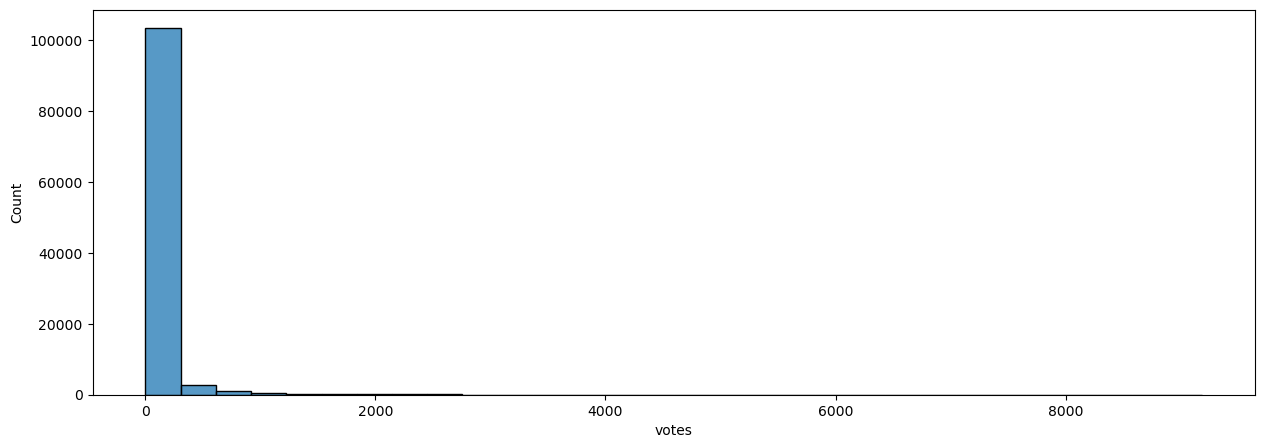

In [86]:
plt.figure(figsize=(15,5))
sns.histplot(data=df_ratings[df_ratings['votes']>1], x='votes', bins=30)

In [87]:
df_ratings.shape

(137202, 5)